In [1]:
import sys
sys.path.append("../")

In [11]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import torch
import torch.nn.functional as F
from torch_scatter import scatter_add

from src.bfsenv import State, BatchedState, MolGraph
from src.models import GraphEmbedding, GraphPolicy, RewardModel
from src.random_graph import grid_graph, binomial_tree_graph
from src.sampler import Sampler

In [25]:

list.index([1, 2, 4, 0, 0, -1], -1)

5

In [12]:
num_node_types = 1
num_edge_types = 1


policy_nn = GraphPolicy(num_node_types, num_edge_types)
reward_nn = RewardModel(num_node_types, num_edge_types)
sampler = Sampler(policy_nn, 40)

p_optim = torch.optim.Adam(
    policy_nn.parameters()
)
r_optim = torch.optim.Adam(
    reward_nn.parameters()
)


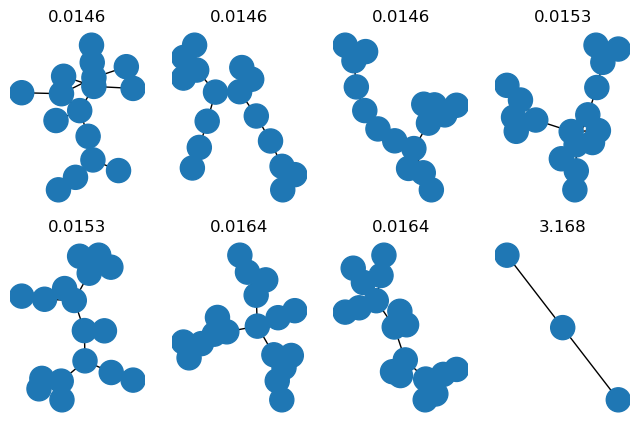

195


In [13]:
import tqdm
from IPython import display
from collections import defaultdict

sample_size = 8


losses = []
# pbar = tqdm.trange(1000)
pbar = range(200)
for i in pbar:
    # sampling
    x_neg = sampler.sample_termial(sample_size)
    x_pos = binomial_tree_graph(size=sample_size)

    with torch.no_grad():
        logR_neg = reward_nn(x_neg)
        logR_pos = reward_nn(x_pos)
        
    # 
    traj_pos = sampler.to_batched_trajectory(x_pos)
    traj_neg = sampler.to_batched_trajectory(x_neg)
    
    # compute loss
    ploss = policy_nn.loss(traj_neg, logR_neg).mean()
    dloss = policy_nn.loss(traj_pos, logR_pos).mean()
    rloss = reward_nn.loss(x_pos, x_neg).mean()
    
    loss = ploss + dloss + rloss

    p_optim.zero_grad()
    r_optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_nn.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(reward_nn.parameters(), 1.0)
    p_optim.step()
    r_optim.step()

        
    if i % 5 == 0:
        rank = torch.argsort(logR_neg)
        
        plt.figure(figsize=(8, 5))
        for k in range(8):
            r = rank[k].item()
            ax = plt.subplot(2, 4, k+1)
            plt.title(str(round(logR_neg[r].exp().item(), 4)))
            x_neg[r].visualize(figsize=None, ax=ax)
            plt.axis("off")
        plt.show()
        print(i)
        display.clear_output(wait=True)
        

    # logging
    loss_info = {
         "logR":logR_neg.mean().item(),
    }
#     pbar.set_postfix(loss_info)

    losses.append(loss_info)
    
history = pd.DataFrame(losses)

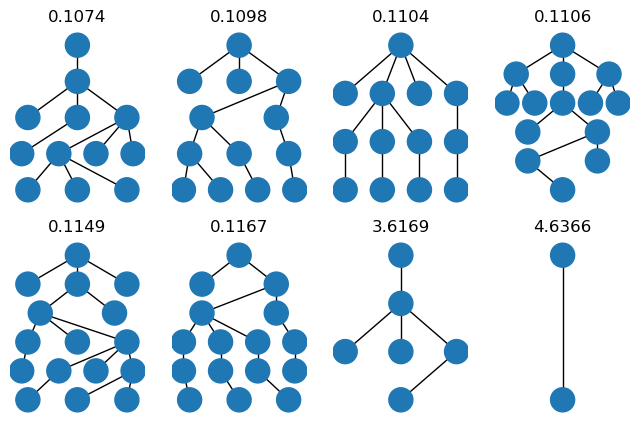

In [20]:
x_neg = sampler.sample_termial(sample_size)

with torch.no_grad():
    neg_logR = reward_nn(x_neg)

rank = torch.argsort(neg_logR)

plt.figure(figsize=(8, 5))
for k in range(8):
    r = rank[k].item()
    ax = plt.subplot(2, 4, k+1)
    plt.title(str(round(neg_logR[r].exp().item(), 4)))
    x_neg[r].visualize(figsize=None, ax=ax, bfs_root=0)
    plt.axis("off")
plt.show()

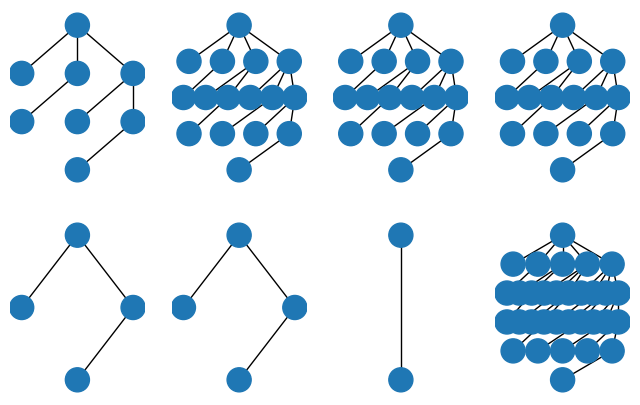

In [16]:
pos_logR = log_reward(pos_x)
rank = torch.argsort(pos_logR)

plt.figure(figsize=(8, 5))
for k in range(8):
    r = rank[k].item()
    ax = plt.subplot(2, 4, k+1)
    # plt.title(str(round(pos_logR[r].exp().item(), 4)))
    x_pos[r].visualize(figsize=None, ax=ax, bfs_root=0)
    plt.axis("off")
plt.show()